In [131]:
exp_numb=0
frame_width=640
frame_height=480
fps=90
number_of_frames_to_record=500
background_chunk=200 #I want to use 500 frames for recording the background
preset_json_file="d415paramset_640480.json"
grand_frame=int(exp_numb*(number_of_frames_to_record-background_chunk))
min_range=0
max_range=1000
data_chunk_size=50
box_size=192 #this is how big I want my video to be (200 by 200) #YOU WILL GET ERRORS IF YOU'RE BOX IS BIGGER THAN THE MIDDLE OF THE IMAGE (x or y)
dpi=80

In [83]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [84]:
import sys
sys.path.append('/usr/local/lib')

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcol
import matplotlib.cm as cm
import math
import imageio
import time
import pandas as pd
import json
import pyrealsense2 as rs
import cv2
from scipy import stats
from scipy import ndimage #for finding com
from scipy.misc import imsave
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [86]:
!mkdir dlc_Movie
#!mkdir d415_Movie

mkdir: cannot create directory ‘dlc_Movie’: File exists


In [87]:
# Enabling Advanced Mode

DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No device that supports advanced mode was found")

try:
    dev = find_device_that_supports_advanced_mode()
    advnc_mode = rs.rs400_advanced_mode(dev)
    print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    # Loop until we successfully enable advanced mode
    while not advnc_mode.is_enabled():
        print("Trying to enable advanced mode...")
        advnc_mode.toggle_advanced_mode(True)
        # At this point the device will disconnect and re-connect.
        print("Sleeping for 5 seconds...")
        time.sleep(5)
        # The 'dev' object will become invalid and we need to initialize it again
        dev = find_device_that_supports_advanced_mode()
        advnc_mode = rs.rs400_advanced_mode(dev)
        print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    
except Exception as e:
    print(e)
pass

Found device that supports advanced mode: Intel RealSense D415
Advanced mode is enabled


In [88]:
# Loading presaved parameters 
# If I have another set of parameters I'd like to use already in the json format, I can skip the previous three blocks of code
    
with open(preset_json_file) as json_data: #Json file to be loaded #NOTE im using default NOT the json that I just created above
    starting_params = json.load(json_data)
    starting_params=str(starting_params).replace("'", '\"') #IF YOU DON't DO THIS IT WILL NOT WORK with the librealsense sdk
    print(starting_params)

{"aux-param-autoexposure-setpoint": "400", "aux-param-colorcorrection1": "0.461914", "aux-param-colorcorrection10": "-0.553711", "aux-param-colorcorrection11": "-0.553711", "aux-param-colorcorrection12": "0.0458984", "aux-param-colorcorrection2": "0.540039", "aux-param-colorcorrection3": "0.540039", "aux-param-colorcorrection4": "0.208008", "aux-param-colorcorrection5": "-0.332031", "aux-param-colorcorrection6": "-0.212891", "aux-param-colorcorrection7": "-0.212891", "aux-param-colorcorrection8": "0.68457", "aux-param-colorcorrection9": "0.930664", "aux-param-depthclampmax": "65536", "aux-param-depthclampmin": "0", "aux-param-disparityshift": "0", "controls-autoexposure-auto": "True", "controls-autoexposure-manual": "33000", "controls-color-autoexposure-auto": "True", "controls-color-autoexposure-manual": "166", "controls-color-backlight-compensation": "0", "controls-color-brightness": "0", "controls-color-contrast": "50", "controls-color-gain": "64", "controls-color-gamma": "300", "co

In [89]:
#Experimental Loop
file = open('pythondepthdata.bin', 'a+b') #open a file for apending binary data
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, frame_width, frame_height, rs.format.z16, fps)
#config.enable_stream(rs.stream.color, frame_width, frame_height, rs.format.bgr8, fps)
advnc_mode.load_json(starting_params) #this is where I start with the Defualt Json
# Start streaming
cfg = pipeline.start(config)
dev = cfg.get_device()
depth_sensor = dev.first_depth_sensor()
#depth_sensor.set_option(rs.option.visual_preset, 2)
#hff = rs.hole_filling_filter()    
#hff.set_option(rs.option.holes_fill, 1)
sf=rs.spatial_filter()
#sf.set_option()

iteration = 0;
#preset = 0;
#preset_name = '';
tick=0; #keeping track of the number of loops the experiment has gone through 


In [90]:
start_of_loop=time.time()
with open('pythondepthdata.bin','ab') as binarydata: #While the file called "pythonedpthdata.bin" is open for appending binary, 
    try:
        while tick<number_of_frames_to_record: #aiming for 2000 frames
            tick=tick+1 
            
            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
            depth_frame = sf.process(depth_frame); #apply a hole filling filter

            #color_frame = frames.get_color_frame()

            #iteration = iteration + 1
            #if iteration > 100:
               #preset = preset + 1
               #iteration = 0
               #range = depth_sensor.get_option_range(rs.option.visual_preset)
               #preset = preset % range.max
               #depth_sensor.set_option(rs.option.visual_preset, preset)
               #preset_name = depth_sensor.get_option_value_description(rs.option.visual_preset, preset)
        
            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            #color_image = np.asanyarray(color_frame.get_data())
            depth_image.tofile(binarydata) #save data as binarydata (specified by the with open as line)
            
            if tick==background_chunk:
                output=input("please insert object to record and enter YYMMDD_exp#  ")
        
            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            #depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, None, 0.5, 0), cv2.COLORMAP_JET)

            # Stack both images horizontally
            #images = np.hstack((color_image, depth_colormap))
        
            #font = cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(images, preset_name,(60,80), font, 4,(255,255,255),2,cv2.LINE_AA) 

            # Show images
            #cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            #cv2.imshow('RealSense', images)
            #cv2.waitKey(1)
            with open('depth_ts.txt', 'a') as ts:
                ts.write('%s\n' %rs.frame.get_timestamp(frames)) #write time stamp float as a string to a new line

    finally:

        # Stop streaming
        pipeline.stop()
        end_of_loop=time.time() #end timer
        print("Time Elapsed = ", end_of_loop - start_of_loop)
        serialized_string = advnc_mode.serialize_json() #getting the current parameters as a serialized string
        as_json_object = json.loads(serialized_string) #loading the json object from the serialized string
        json_used_in_experiment = str(as_json_object).replace("'", '\"') #converting object into string that can be printed
        print("Final Parameters = ", json_used_in_experiment)

please insert object to record and enter YYMMDD_exp#  k
Time Elapsed =  14.230056524276733
Final Parameters =  {"aux-param-autoexposure-setpoint": "400", "aux-param-colorcorrection1": "0.461914", "aux-param-colorcorrection10": "-0.553711", "aux-param-colorcorrection11": "-0.553711", "aux-param-colorcorrection12": "0.0458984", "aux-param-colorcorrection2": "0.540039", "aux-param-colorcorrection3": "0.540039", "aux-param-colorcorrection4": "0.208008", "aux-param-colorcorrection5": "-0.332031", "aux-param-colorcorrection6": "-0.212891", "aux-param-colorcorrection7": "-0.212891", "aux-param-colorcorrection8": "0.68457", "aux-param-colorcorrection9": "0.930664", "aux-param-depthclampmax": "65536", "aux-param-depthclampmin": "0", "aux-param-disparityshift": "0", "controls-autoexposure-auto": "True", "controls-autoexposure-manual": "33000", "controls-color-autoexposure-auto": "True", "controls-color-autoexposure-manual": "166", "controls-color-backlight-compensation": "0", "controls-color-bri

In [136]:
#get background frames
background_frames = np.fromfile('pythondepthdata.bin', dtype=np.uint16, count=(int(frame_height*frame_width*background_chunk*16))).reshape(-1, frame_height, frame_width)[0:background_chunk] #A highly efficient way of reading binary data with a known data-type, as well as parsing simply formatted text files. Data written using the tofile method can be read using this function.

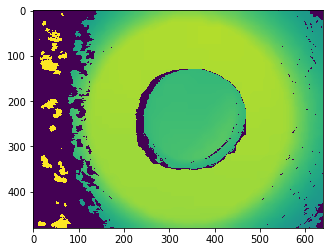

In [137]:
plt.imshow(background_frames[100])
plt.clim(0,1000)

In [139]:
#Making a movie for Deep Lab Cut
number_of_frames=number_of_frames_to_record
video_width=frame_width
video_height=frame_height
backgroundmean=np.mean(background_frames, axis=0) #may be better to use median
backgroundvariance=np.var(background_frames, axis=0)


for batch_number in range(int((number_of_frames-background_chunk)/data_chunk_size)):

    frames = np.fromfile('pythondepthdata.bin', dtype=np.uint16, count=(int(frame_height*frame_width*background_chunk*16))).reshape(-1, frame_height, frame_width)[background_chunk+(batch_number*data_chunk_size):background_chunk+(batch_number*data_chunk_size)+data_chunk_size]
    current_frame=0
    for f in range(int(data_chunk_size)):
        
        #FRAME TO PROCESS
        frame_of_interest=frames[current_frame] 
        
        #IF PIXEL ISN'T SIGNIFICANTLY DIFFERENT FROM THE BACKGROUND THEN DROP IT
        backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (15*np.sqrt(backgroundvariance)) 
        
        #WE EXPECT POSITIVE VALUES FOR HIGH DIFFERENCES make them stay by multiplying by 1
        backgroundmultiplier[backgroundmultiplier>0]=1
        #WE EXPECT NEGATIVE VALUES FOR SMALL OR NO DIFFERENCE probably just noise, get rid of them by multiplying by 0
        backgroundmultiplier[backgroundmultiplier<=0]=0
       
        # SUBTRACT BACKGROUND BY MULTIPLYING INSIGNIFIACNT FRAMES BY ZERO
        frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>max_range]=0
        frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted<=min_range]=0
        frame_of_interest_backgroundsubtracted=(np.multiply(frame_of_interest,backgroundmultiplier)).astype('uint8') #IMWRITE TAKES UINT8
        
        #################################################################
        #ALGORITHIM FOR FINDING THE CENTER OF THE OBJECT (TO CROP THE PLOT) (this actually works better than any built in function I've tried)
        #basically, the row and column with the most non zero values should be the center
        
        winningrow=0
        winningcountr=video_width
        for rowpixels in range(0,video_height):
            currentcountr=np.count_nonzero(frame_of_interest_backgroundsubtracted[rowpixels,:]==0)
            if currentcountr<winningcountr:
                winningcountr=currentcountr
                winningrow=rowpixels

        winningcolumn=0
        winningcountc=video_height
        for columnpixels in range(0,video_width):
            currentcountc=np.count_nonzero(frame_of_interest_backgroundsubtracted[:,columnpixels]==0)
            if currentcountc<winningcountc:
                winningcountc=currentcountc
                winningcolumn=columnpixels

        if winningrow<(box_size/2):
            winningrow=(int(box_size/2))
        if winningrow>(video_height-box_size/2):
            winningrow=int(video_height-box_size/2-1)
        if winningcolumn<(box_size/2):
             winningcolumn=(int(box_size/2))
        if winningcolumn>(video_width-box_size/2):
            winningcolumn=int(video_width-box_size/2-1)
        
        ####################################################################

        #THIS IS THE FRAME NUMBER (I WILL COMBINE MANY RUNS SO I'M OUTPUTTING THE MASTER FRAME NUMBER)
        fplusd=int(f+grand_frame+(batch_number*data_chunk_size))
        print(fplusd)
       

        # THIS IS HOW I SHOULD SAVE ARRAYS SO THEY COME OUT AS 192 by 192 FOR IMAGE ANALYSIS (IT'S SMALLER!)
        imageio.imwrite('/home/rockwell/Real_Sensible_Moseq/data_acquisition/dlc_Movie/dlc_frame_%06d.png'%fplusd,frame_of_interest_backgroundsubtracted[winningrow-int(box_size/2):winningrow+int(box_size/2),winningcolumn-int(box_size/2):winningcolumn+int(box_size/2)])

        current_frame=current_frame+1
        
        
    

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
0
50
1
51
2
52
3
53
4
54
5
55
6
56
7
57
8
58
9
59
10
60
11
61
12
62
13
63
14
64
15
65
16
66
17
67
18
68
19
69
20
70
21
71
22
72
23
73
24
74
25
75
26
76
27
77
28
78
29
79
30
80
31
81
32
82
33
83
34
84
35
85
36
86
37
87
38
88
39
89
40
90
41
91
42
92
43
93
44
94
45
95
46
96
47
97
48
98
49
99
0
100
1
101
2
102
3
103
4
104
5
105
6
106
7
107
8
108
9
109
10
110
11
111
12
112
13
113
14
114
15
115
16
116
17
117
18
118
19
119
20
120
21
121
22
122
23
123
24
124
25
125
26
126
27
127
28
128
29
129
30
130
31
131
32
132
33
133
34
134
35
135
36
136
37
137
38
138
39
139
40
140
41
141
42
142
43
143
44
144
45
145
46
146
47
147
48
148
49
149
0
150
1
151
2
152
3
153
4
154
5
155
6
156
7
157
8
158
9
159
10
160
11
161
12
162
13
163
14

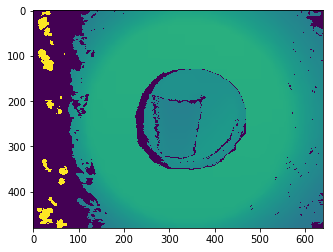

In [140]:
plt.imshow(frame_of_interest)
plt.clim(0,1000)

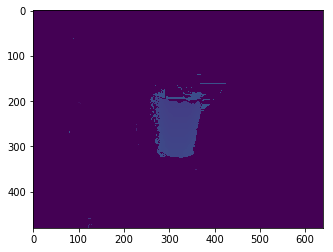

In [141]:
plt.imshow(frame_of_interest_backgroundsubtracted)
plt.clim(0,1000)

In [ ]:
#delete all variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [ ]:
#background subtracted Movie as an MP4! Perfect data input for leap
!ffmpeg -i /home/rockwell/Real_Sensible_Moseq/data_acquisition/dlc_Movie/dlc_frame_%06d.png -c:v libx264 -vf fps=90 -pix_fmt yuv420p -r 90 dlc_out.mp4

In [81]:
!rm pythondepthdata.bin 
!rm depth_ts.txt 
#rm -r d415_Movie/
#rm -r dlc_Movie/